<a href="https://colab.research.google.com/github/EdwardFang09/questionable-youtube-video-title/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset diambil dari file youtube_data.csv yang merupakan kumpulan data judul video YouTube milik SoraSkyAtic, seorang kreator konten animasi Minecraft.

Struktur Dataset: Dataset terdiri dari 272 data dengan kolom sebagai berikut:
- Content: ID video unik di YouTube.
- video_title: Judul video yang digunakan di YouTube, lengkap dengan tagar.
- Video publish time: Tanggal video diterbitkan (format: Bulan, Tanggal, Tahun).
- views: Jumlah penonton video hingga saat ini.

In [1]:
import csv

with open('youtube_data.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        print(row)

['Content', 'video_title', 'Video publish time', 'views']
['Total', '', '', '2811051']
['c9bw-s1JYEA', "Dream's Mannequin Prank (SUS) (Dreamnotfound Animation) #minecraft #sus #cursed", 'Aug 31, 2024', '349252']
['4HRoknbTl1A', "What's The Point Of The MASK??? [Dreamnotfound Minecraft Animation] #shorts #sus #dream", 'Mar 16, 2024', '288905']
['tUzJOAMwdok', "Dream's new challenge be like (Fridge in Nuke Explosion) #minecraft #dream #georgenotfound", 'Oct 23, 2024', '124621']
['IWiPMhzdZrI', 'GeorgeNotFound Stuck at SUS Elevator Animation', 'May 15, 2022', '120739']
['eSCcCFSHKko', 'Sapnap Is Giving Away SUSSY Cereals For A Limited Time! | #ohdreamsgiveaway Animation', 'Jul 10, 2022', '115644']
['mfFnW36jKDg', "Dream 'Tortures' GeorgeNotFound... But It's SUS | Dream SMP Animation", 'Feb 5, 2022', '113595']
['tTdUtb2XQ_0', "Sapnap's Sad Anime AMONG US Eye #shorts", 'Oct 14, 2022', '110250']
['CwhO_zojQmU', "Dream is GeorgeNotFound's (Dreamnotfound Animation) #sus #dream #georgenotfound"

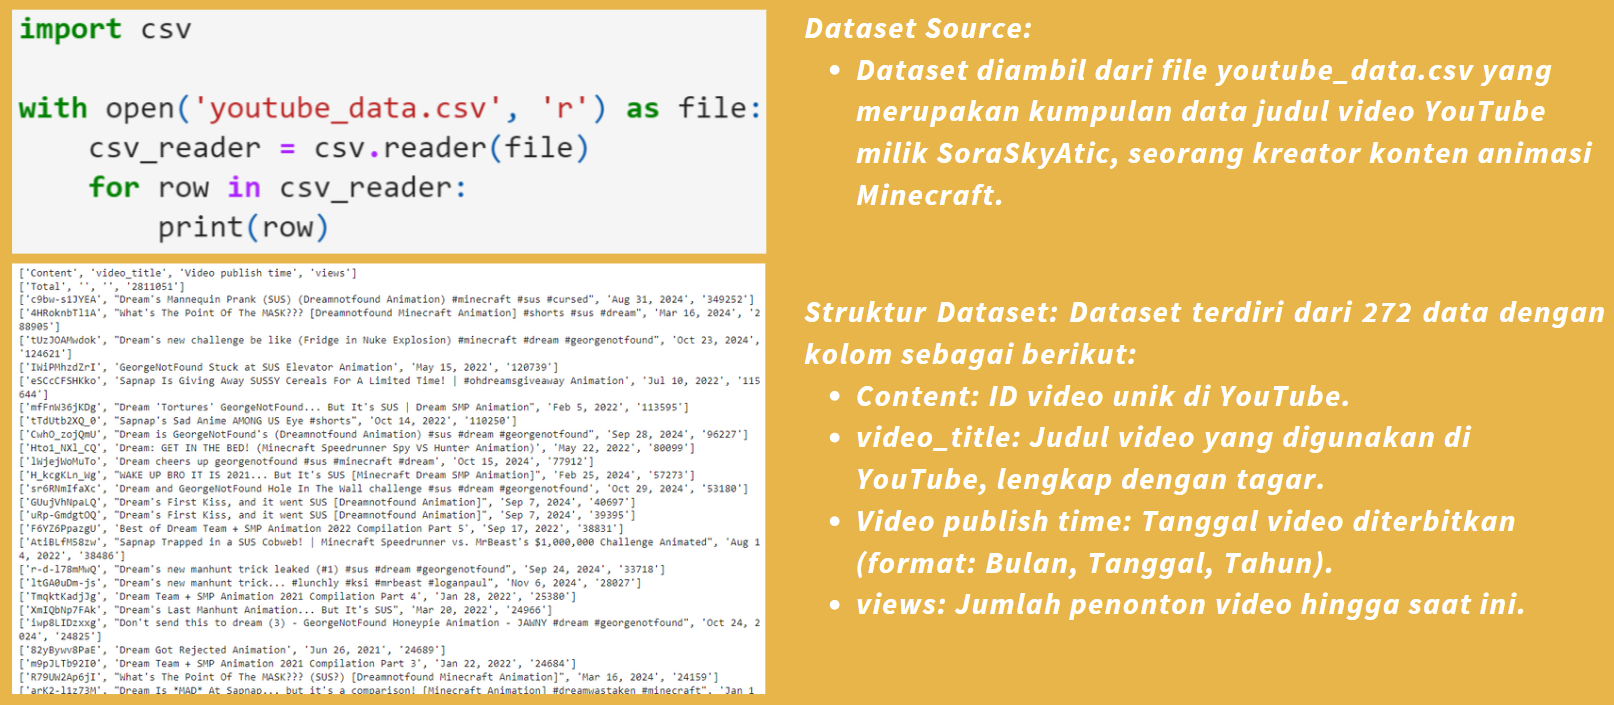

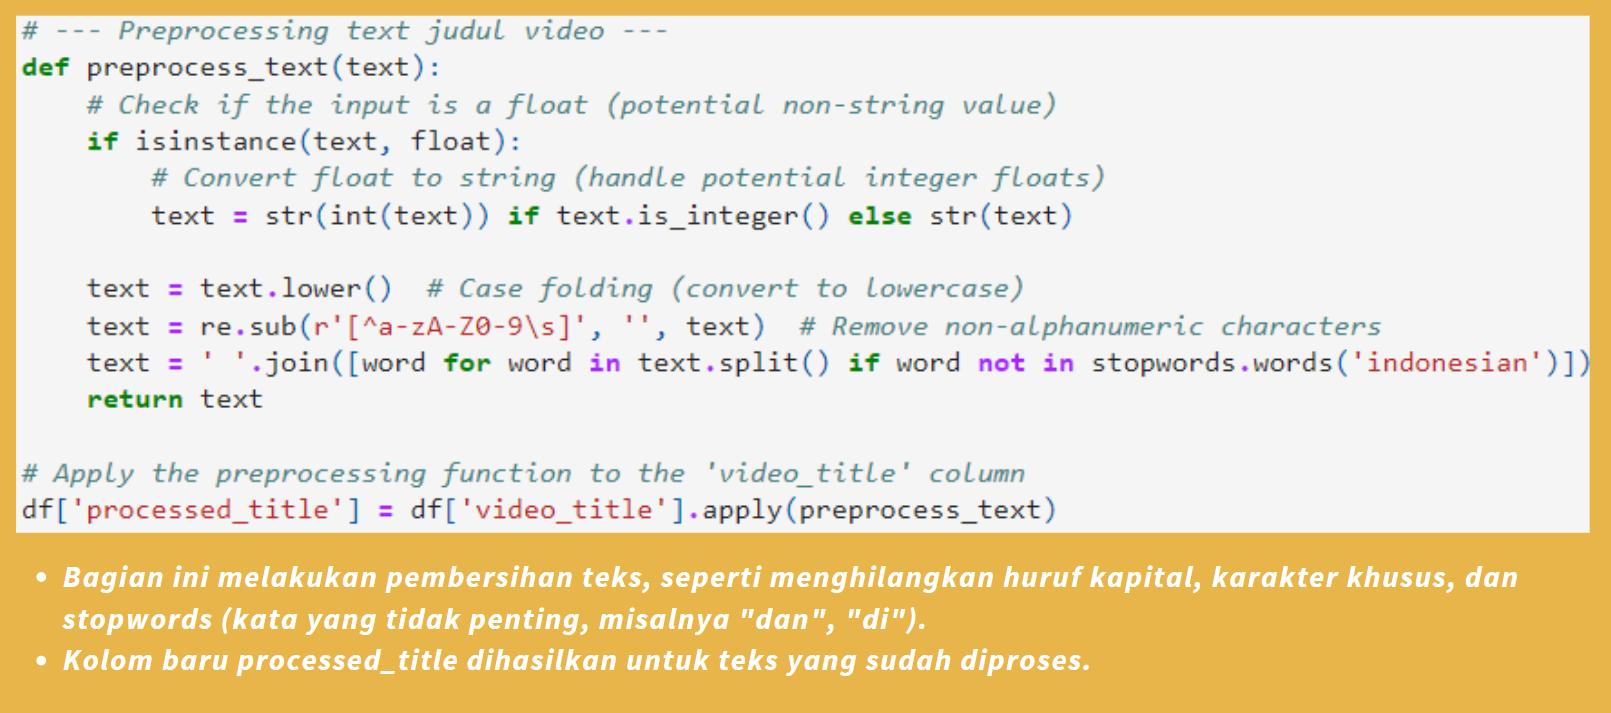

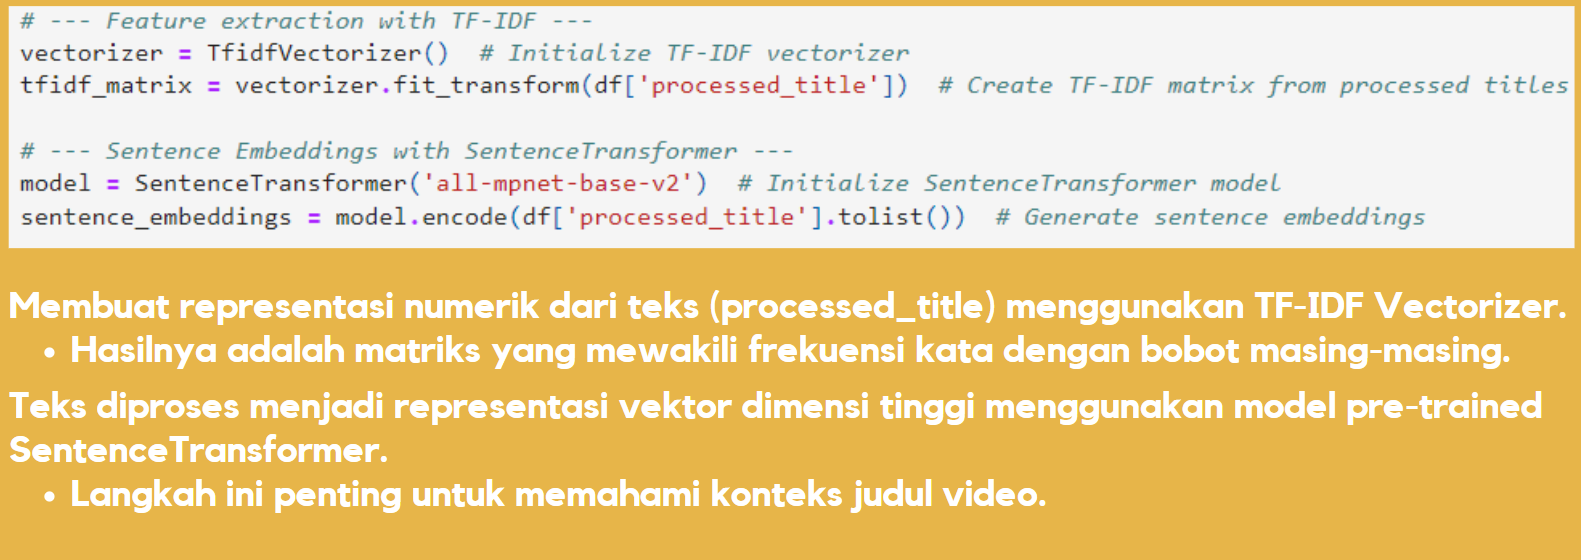

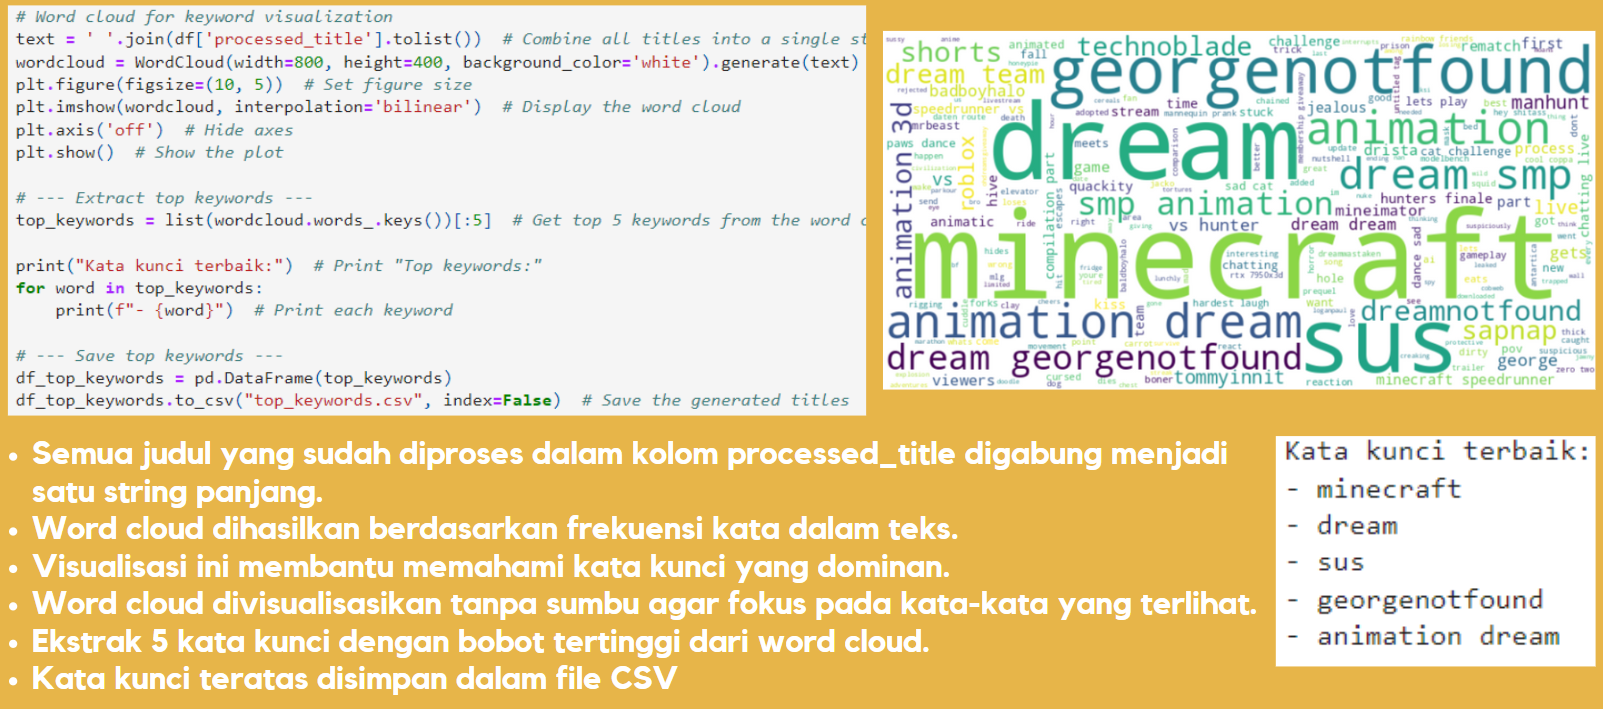

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


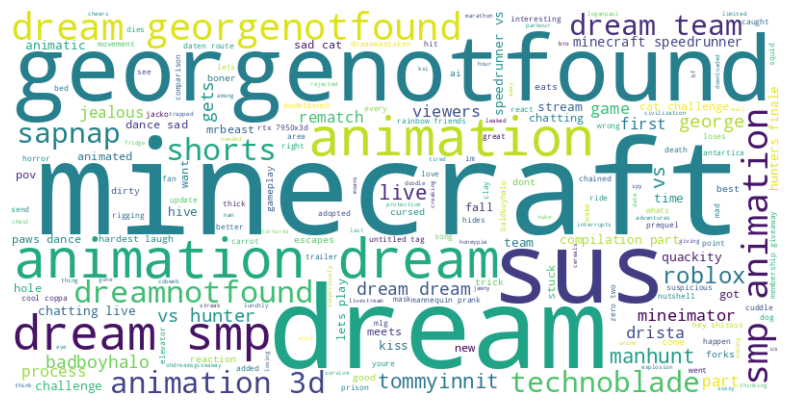

Kata kunci terbaik:
- minecraft
- dream
- sus
- georgenotfound
- animation dream


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sentence_transformers import SentenceTransformer

# Load data from youtube_data.csv
df = pd.read_csv("youtube_data.csv")

# --- Preprocessing text judul video ---
def preprocess_text(text):
    # Check if the input is a float (potential non-string value)
    if isinstance(text, float):
        # Convert float to string (handle potential integer floats)
        text = str(int(text)) if text.is_integer() else str(text)

    text = text.lower()  # Case folding (convert to lowercase)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    return text

# Apply the preprocessing function to the 'video_title' column
df['processed_title'] = df['video_title'].apply(preprocess_text)

# --- Feature extraction with TF-IDF ---
vectorizer = TfidfVectorizer()  # Initialize TF-IDF vectorizer
tfidf_matrix = vectorizer.fit_transform(df['processed_title'])  # Create TF-IDF matrix from processed titles

# --- Sentence Embeddings with SentenceTransformer ---
model = SentenceTransformer('all-mpnet-base-v2')  # Initialize SentenceTransformer model
sentence_embeddings = model.encode(df['processed_title'].tolist())  # Generate sentence embeddings

# Word cloud for keyword visualization
text = ' '.join(df['processed_title'].tolist())  # Combine all titles into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  # Generate word cloud
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud
plt.axis('off')  # Hide axes
plt.show()  # Show the plot

# --- Extract top keywords ---
top_keywords = list(wordcloud.words_.keys())[:5]  # Get top 5 keywords from the word cloud

print("Kata kunci terbaik:")  # Print "Top keywords:"
for word in top_keywords:
    print(f"- {word}")  # Print each keyword

# --- Save top keywords ---
df_top_keywords = pd.DataFrame(top_keywords)
df_top_keywords.to_csv("top_keywords.csv", index=False)  # Save the generated titles

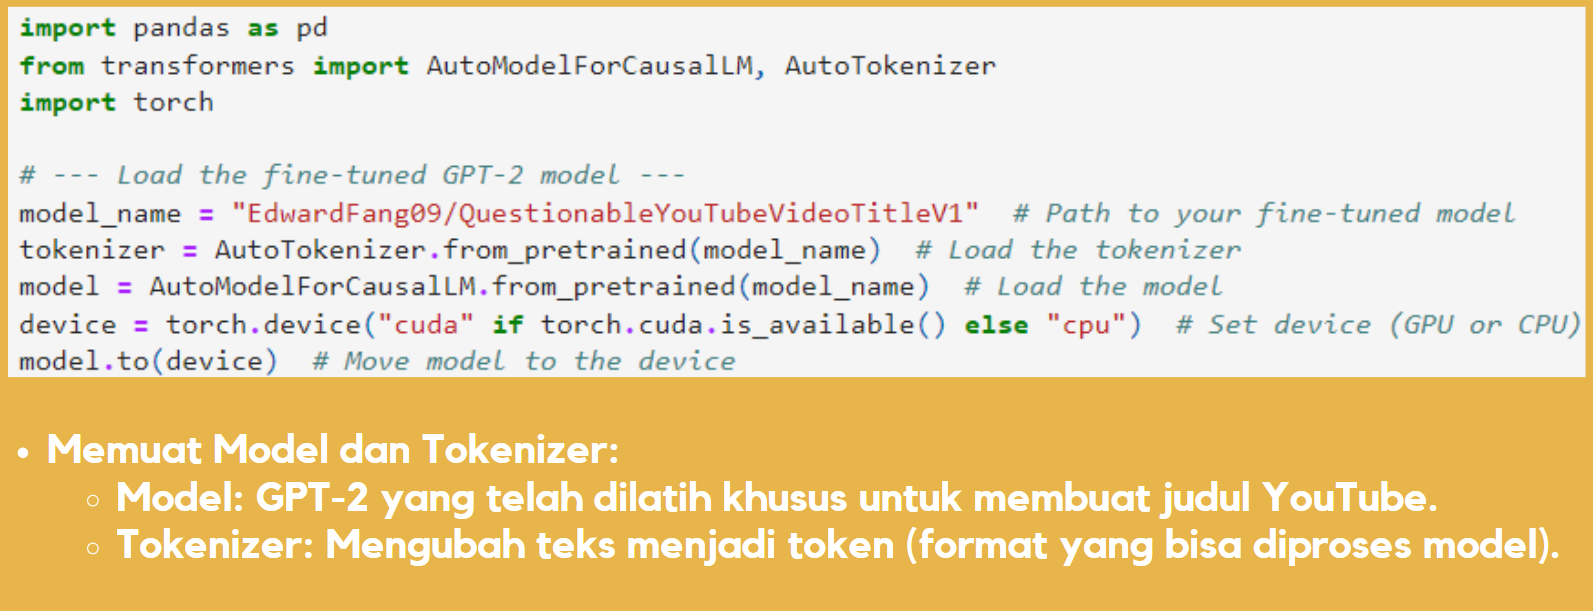

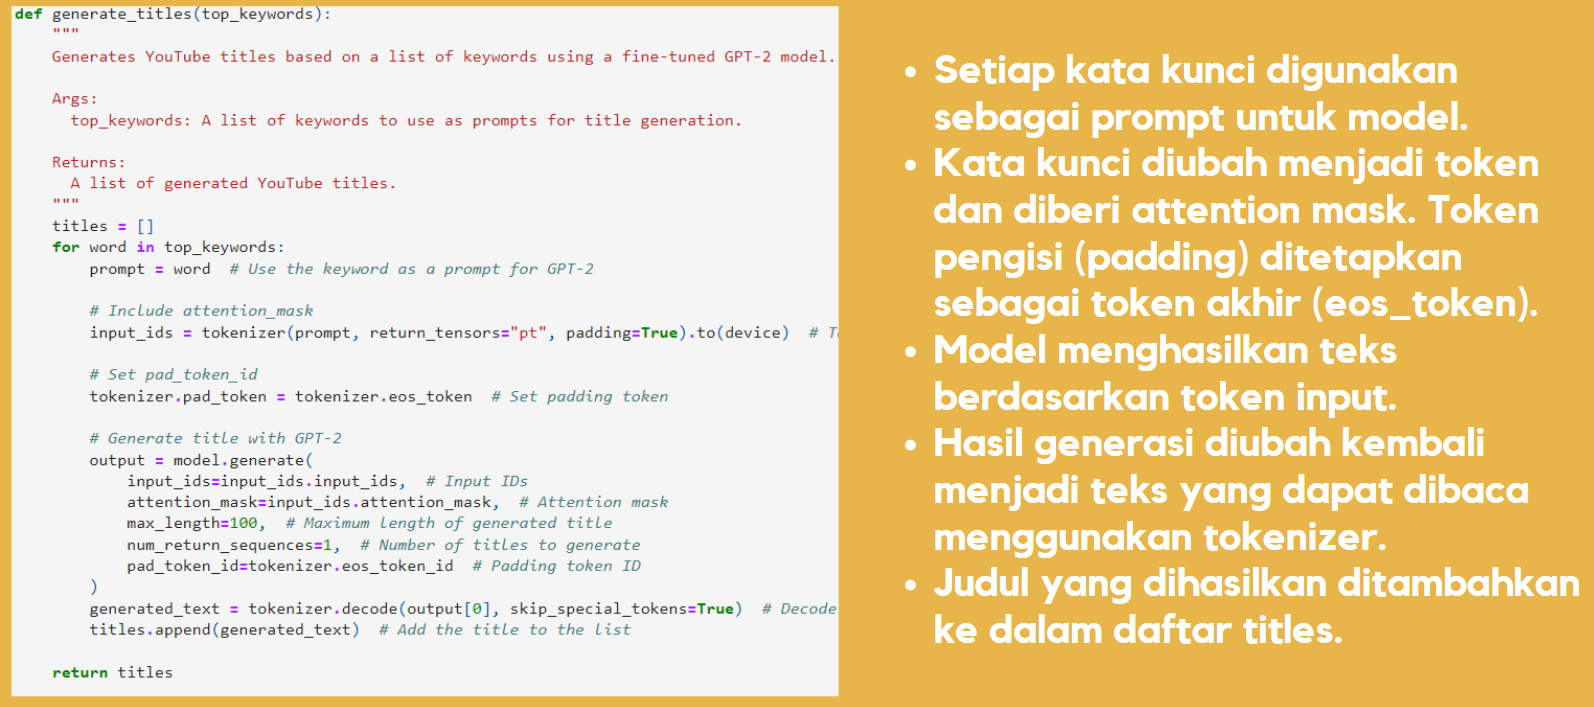

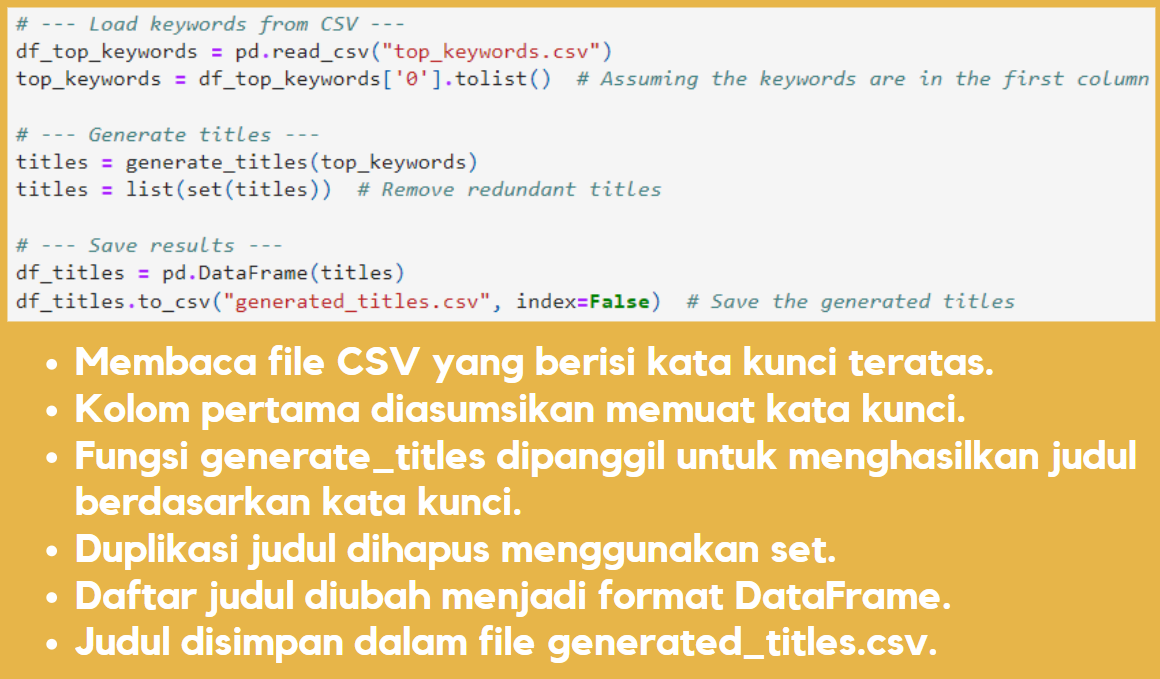

____
Load Model Generator

In [3]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# --- Load the fine-tuned GPT-2 model ---
model_name = "EdwardFang09/QuestionableYouTubeVideoTitleV1"  # Path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load the tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)  # Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device (GPU or CPU)
model.to(device)  # Move model to the device


def generate_titles(top_keywords):
    """
    Generates YouTube titles based on a list of keywords using a fine-tuned GPT-2 model.

    Args:
      top_keywords: A list of keywords to use as prompts for title generation.

    Returns:
      A list of generated YouTube titles.
    """
    titles = []
    for word in top_keywords:
        prompt = word  # Use the keyword as a prompt for GPT-2

        # Include attention_mask
        input_ids = tokenizer(prompt, return_tensors="pt", padding=True).to(device)  # Tokenize the prompt

        # Set pad_token_id
        tokenizer.pad_token = tokenizer.eos_token  # Set padding token

        # Generate title with GPT-2
        output = model.generate(
            input_ids=input_ids.input_ids,  # Input IDs
            attention_mask=input_ids.attention_mask,  # Attention mask
            max_length=100,  # Maximum length of generated title
            num_return_sequences=1,  # Number of titles to generate
            pad_token_id=tokenizer.eos_token_id  # Padding token ID
        )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)  # Decode the generated title
        titles.append(generated_text)  # Add the title to the list

    return titles


# --- Load keywords from CSV ---
df_top_keywords = pd.read_csv("top_keywords.csv")
top_keywords = df_top_keywords['0'].tolist()  # Assuming the keywords are in the first column

# --- Generate titles ---
titles = generate_titles(top_keywords)
titles = list(set(titles))  # Remove redundant titles

# --- Save results ---
df_titles = pd.DataFrame(titles)
df_titles.to_csv("generated_titles.csv", index=False)  # Save the generated titles

Top keywords

In [4]:
top_keywords

['minecraft', 'dream', 'sus', 'georgenotfound', 'animation dream']

High Quality titles

In [5]:
# --- Generate high quality titles ---
print("\nIde judul: ")
for i in range(0,len(top_keywords)):
    #print(f"{((top_keywords)[i])}: {titles[i]}")
    print(f"{titles[i]}")


Ide judul: 
dream's new manhunt trick leaked... but it's a joke! [Minecraft Animation] #dream #minecraft #georgenotfound
georgenotfound #minecraft #georgenotfound
sus #shorts #dream
minecraft's new manhunt trick... but it's a hoax... [Minecraft Animation]
animation dream (SUS) #dream #dream


Outputs
- Menghasilkan judul video bergaya YouTuber 'SoraSkyAtic'.
- Output dari test.ipynb
    - Kata kunci yang viewsnya tinggi. (top_keywords.csv)
    - Judul video dengan potensi views tinggi. (generated_titles.csv)